In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# New Section

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NAIA Daily Data.csv")
#Removing missing values
data = data[data.TMAX != -999]
data = data[data.RAINFALL != -999]

data.corr()

,YEAR,MONTH,DAY,RAINFALL,TMAX,TMIN,RH,STATION_PRESSURE
YEAR,1.000000,0.023300,-0.015981,0.037449,-0.054400,0.061635,0.100659,-0.197187
MONTH,0.023300,1.000000,0.013762,0.138842,-0.162172,0.164976,0.397468,-0.356118
DAY,-0.015981,0.013762,1.000000,0.025886,0.013427,0.053199,0.056982,-0.042716
RAINFALL,0.037449,0.138842,0.025886,1.000000,-0.250039,-0.179003,0.461125,-0.371994
TMAX,-0.054400,-0.162172,0.013427,-0.250039,1.000000,0.563556,-0.519756,-0.022119
TMIN,0.061635,0.164976,0.053199,-0.179003,0.563556,1.000000,-0.059711,-0.407337
RH,0.100659,0.397468,0.056982,0.461125,-0.519756,-0.059711,1.000000,-0.495071
STATION_PRESSURE,-0.197187,-0.356118,-0.042716,-0.371994,-0.022119,-0.407337,-0.495071,1.000000


Determines the correlation of each variables to each other.

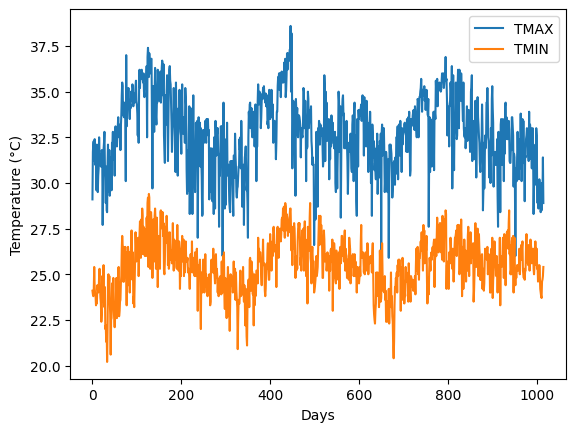

In [ ]:
x = np.array(range(0,len(data)))
plt.plot(x, data['TMAX'], label='TMAX')
plt.plot(x, data['TMIN'], label='TMIN')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.show()

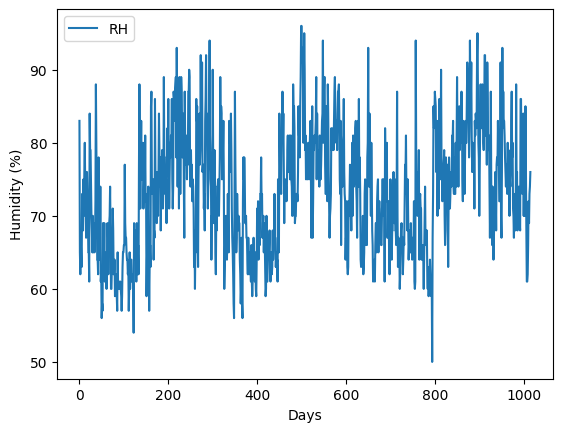

In [ ]:
plt.plot(x, data['RH'], label='RH')
plt.legend()
plt.xlabel('Days')
plt.ylabel('Humidity (%)')
plt.show()

In [ ]:
#Indexing the dataframe based on year, month, and day just in case
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NAIA Daily Data.csv", index_col = ["YEAR"])

#Removing missing values
data = data[data.TMAX != -999]
data = data[data.RAINFALL != -999]

#convert dataframe to array
data = np.array(data.loc[:, ["TMAX", "TMIN", "RH"]])

#Adding target values for 3 days of previous data
dataX = []
dataY = []

n_future = 1
n_past = 3

for i in  range(n_past, len(data) - n_future + 1):
  dataX.append(data[i - n_past:i, 0:data.shape[0]])
  dataY.append([data[i + n_future - 1:i + n_future, 0]])
  #, data[i + n_future - 1:i + n_future, 3]

ORIGINAL MODEL

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.activations import swish

dataX = np.array(dataX)
dataY = np.array(dataY)

trainX, valX, testX  = np.split(dataX, [int(.7*len(dataX)), int(.8*len(dataX))])
trainY, valY, testY = np.split(dataY, [int(.7*len(dataY)), int(.8*len(dataY))])

#define model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(32, activation='relu', return_sequences = False))
model.add(Dense(64, 'relu'))
model.add(Dense(32, 'relu'))
model.add(Dense(16, 'relu'))
model.add(Dense(8, 'swish'))
model.add(Dense(trainY.shape[1], 'linear'))

MODEL COMPILE

In [ ]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss=['mse', 'mae'], metrics=["mse", "mae"])

In [ ]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX, testY), verbose=1, callbacks=[cp])

Epoch 1/100
24/24 [==============================] - 12s 390ms/step - loss: 466.7371 - mse: 466.7371 - mae: 19.1803 - val_loss: 92.5638 - val_mse: 92.5638 - val_mae: 9.3374
Epoch 2/100
24/24 [==============================] - 5s 237ms/step - loss: 20.9147 - mse: 20.9147 - mae: 3.7095 - val_loss: 12.5989 - val_mse: 12.5989 - val_mae: 3.0679
Epoch 3/100
24/24 [==============================] - 7s 296ms/step - loss: 4.8147 - mse: 4.8147 - mae: 1.6996 - val_loss: 3.1682 - val_mse: 3.1682 - val_mae: 1.3516
Epoch 4/100
24/24 [==============================] - 5s 229ms/step - loss: 2.7524 - mse: 2.7524 - mae: 1.2760 - val_loss: 2.7141 - val_mse: 2.7141 - val_mae: 1.2689
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 2.5684 - mse: 2.5684 - mae: 1.2166 - val_loss: 2.7506 - val_mse: 2.7506 - val_mae: 1.3172
Epoch 6/100
24/24 [==============================] - 7s 307ms/step - loss: 2.5417 - mse: 2.5417 - mae: 1.2154 - val_loss: 2.6792 - val_mse: 2.6792 - val_mae: 1.2541

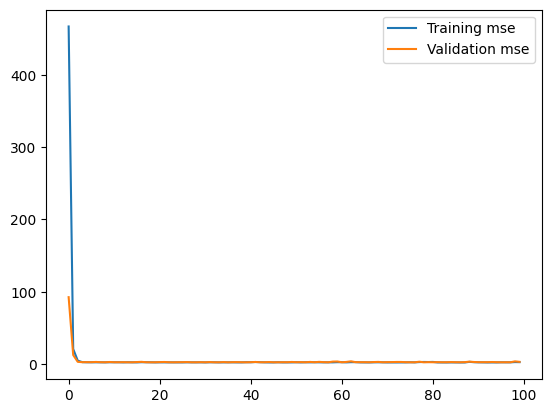

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Training mse')
plt.plot(history.history['val_mse'], label='Validation mse')
plt.legend()


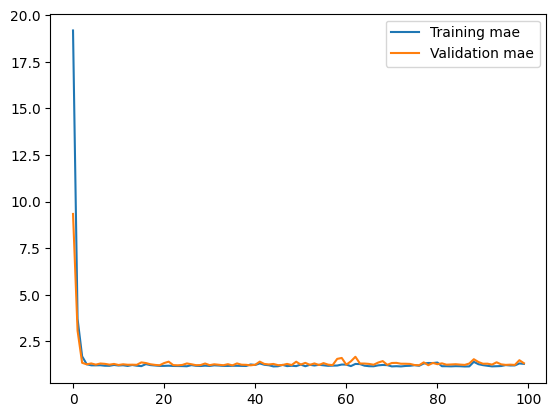

In [ ]:
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.legend()

In [ ]:
from keras.models import load_model
model1 = load_model('model/')

In [ ]:
test_predictions = model.predict(valX)
test_results = pd.DataFrame(data={'Predictions TMAX':test_predictions[:,0].flatten(), 'Actuals TMAX':valY[:,0].flatten()}) #,'Predictions TMIN':test_predictions[:,1].flatten(), 'Actuals TMIN':testY[:,1].flatten()

4/4 [==============================] - 0s 4ms/step


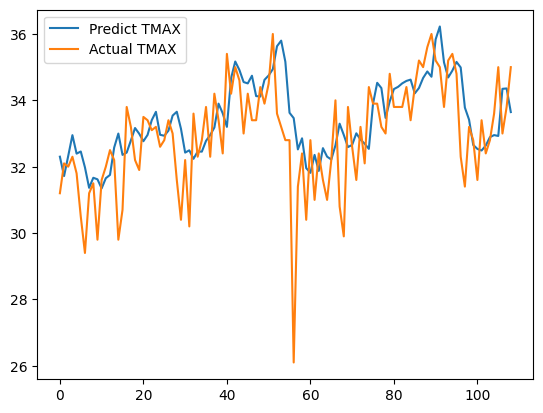

In [ ]:
plt.plot(test_results['Predictions TMAX'], label='Predict TMAX')
plt.plot(test_results['Actuals TMAX'], label='Actual TMAX')
plt.legend()

In [ ]:
print(np.mean(abs(test_results['Predictions TMAX'] - test_results['Actuals TMAX'])))
print(np.mean(pow(test_results['Predictions TMAX'] - test_results['Actuals TMAX'], 2)))
print(np.sqrt(np.mean(pow(test_results['Predictions TMAX'] - test_results['Actuals TMAX'], 2))))

corr_matrix = np.corrcoef(test_results['Actuals TMAX'], test_results['Predictions TMAX'])
corr = corr_matrix[0,1]
R_sq = corr**2

print(R_sq)

1.0111051856924633
1.9519938685601352
1.397137741441457
0.3384876862874244
